In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from utils import load_images, plot_confusion_matrix

# Parameters

In [5]:
N_BREEDS = 3
STD_SIZE = (500, 375)

ENVIRONNEMENT = 'local'
if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/Data/'
else:
    PATH = 'images/'

params = {
    'filter': 'None',
    'box_size': 5,  # Used only with mean, gaussian and median filter
    'n_clusters': 100*N_BREEDS,  
}

# Load images

In [216]:
images_orig, y = load_images(PATH, N_BREEDS, STD_SIZE)

Loaded 1/3: 152 images for breed: Chihuahua
Loaded 2/3: 185 images for breed: Japanese_spaniel
Loaded 3/3: 252 images for breed: Maltese_dog


# Apply filter

In [217]:
images = np.array(images_orig)
if params['filter'] == 'equalize':
    images = [cv2.equalizeHist(img) for img in images]
if params['filter'] == 'mean':
    images = [cv2.blur(img, (params['box_size'], params['box_size'])) for img in images]
if params['filter'] == 'gaussian':
    images = [cv2.GaussianBlur(img, (params['box_size'], params['box_size']), 0) for img in images]
if params['filter'] == 'median':
    images = [cv2.medianBlur(img, params['box_size']) for img in images]
if params['filter'] == 'non-local':
    images = [cv2.fastNlMeansDenoising(img) for img in images]
if params['filter'] == 'whitening':   
    images = np.array(images_orig)
    images_temp = images.reshape(images.shape[0], -1)
    images_temp = images_temp - images_temp.mean(axis=0)
    cov = np.cov(images_temp, rowvar=True)
    U, S, V = np.linalg.svd(cov)
    epsilon = 1e-1
    images_ZCA = np.dot(np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T)), images_temp)
    images_ZCA_rescaled = 255 * (images_ZCA - images_ZCA.min()) / (images_ZCA.max() - images_ZCA.min())
    images = images_ZCA_rescaled.reshape(images.shape[0], 375, 500).astype('uint8') 
images = np.array(images)
print(f"Images pre-processed with {params['filter']} filter")

Images pre-processed with None filter


# Train/test split

In [218]:
images_train, images_test, y_train, y_test = train_test_split(images, y, test_size=0.20, stratify=y, random_state=0)

# Extract SIFT features

In [219]:
sift = cv2.xfeatures2d_SIFT.create()
descriptors = []
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    descriptors.extend([x for x in desc])
print(f'{len(descriptors)} SIFT descriptors detected over {images_train.shape[0]} images')

400348 SIFT descriptors detected over 471 images


# KMeans clustering

In [220]:
kmeans = MiniBatchKMeans(n_clusters=params['n_clusters'], batch_size=10000, random_state=0)
kmeans.fit(descriptors)
print(f'KMeans clustering with {params["n_clusters"]} clusters')

KMeans clustering with 300 clusters


# Inputs

In [221]:
X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
for image in images_test:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [222]:
breed_train = y_train
breed_test = y_test

# Outputs

In [223]:
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

# Train classifier (CV)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    7.9s finished


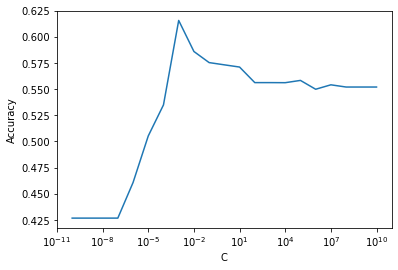

In [224]:
param_grid = {'C': np.logspace(-10, 10, 21)}
model = GridSearchCV(LogisticRegression(max_iter = 100000), param_grid, cv=4, scoring='accuracy', verbose=1)
model.fit(X_train, y_train)

plt.semilogx(model.param_grid['C'], model.cv_results_['mean_test_score'])
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

y_pred = model.predict(X_test)

# Results

## Baseline

----- Accuracy: 61.86 % -----
Filter: None (box size: 5 - only relevant for mean, gaussian and median filters)
n_clusters: 300


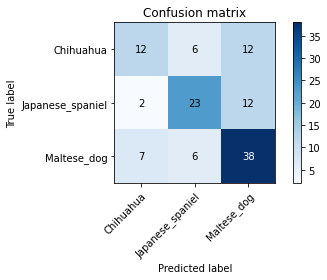

In [161]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Equalization

----- Accuracy: 58.47 % -----
Filter: equalize (box size: 3 - only relevant for mean, gaussian and median filters)
n_clusters: 300


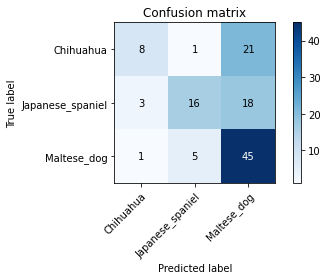

In [24]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Averaging

----- Accuracy: 63.56 % -----
Filter: mean (box size: 5 - only relevant for mean, gaussian and median filters)
n_clusters: 300


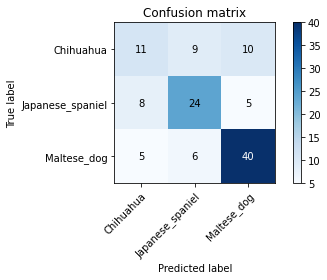

In [45]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Gaussian filter

----- Accuracy: 62.71 % -----
Filter: gaussian (box size: 5 - only relevant for mean, gaussian and median filters)
n_clusters: 300


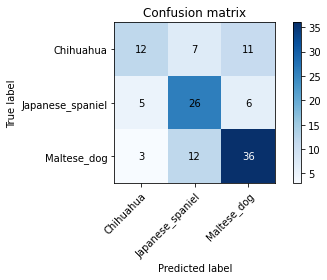

In [64]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Median filter

----- Accuracy: 52.54 % -----
Filter: median (box size: 5 - only relevant for mean, gaussian and median filters)
n_clusters: 300


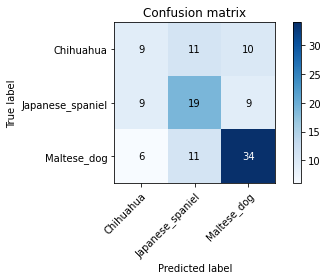

In [74]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Non-local means filter

----- Accuracy: 60.17 % -----
Filter: non-local (box size: 5 - only relevant for mean, gaussian and median filters)
n_clusters: 300


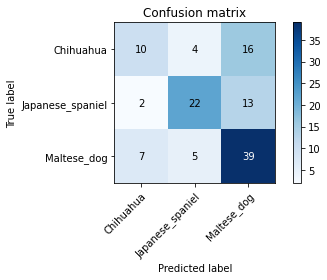

In [84]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## ZCA whitening

----- Accuracy: 55.93 % -----
Filter: whitening (box size: 5 - only relevant for mean, gaussian and median filters)
n_clusters: 300


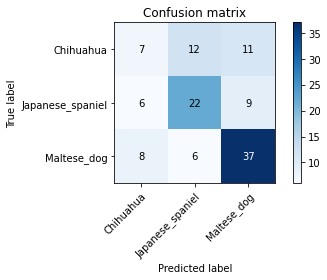

In [94]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Number of clusters

In [166]:
mean_test_score = dict()
accuracies = dict()
for n_clusters in [150, 225, 300, 375, 450, 600, 750]:
    print(f"Starting to test n_clusters = {n_clusters}")
    params["n_clusters"] = n_clusters
    accuracies[n_clusters] = []
    for i in range(10):
        kmeans = MiniBatchKMeans(n_clusters=params["n_clusters"], batch_size=10000)
        kmeans.fit(descriptors)
        X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        for image in images_train:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
        for image in images_test:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)
        le = LabelEncoder().fit(y_train)
        y_train = le.transform(y_train)
        y_test = le.transform(y_test)
        param_grid = {'C': np.logspace(-10, 10, 21)}
        model = GridSearchCV(LogisticRegression(max_iter=1000000), param_grid, cv=4, scoring='accuracy', verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Run n°{i+1} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
        accuracies[n_clusters].append(accuracy_score(y_test, y_pred))
    mean_test_score[n_clusters] = np.mean(accuracies[n_clusters])

Starting to test n_clusters = 150
Run n°1 - Accuracy: 53.39
Run n°2 - Accuracy: 55.93
Run n°3 - Accuracy: 61.02
Run n°4 - Accuracy: 58.47
Run n°5 - Accuracy: 58.47
Run n°6 - Accuracy: 56.78
Run n°7 - Accuracy: 57.63
Run n°8 - Accuracy: 57.63
Run n°9 - Accuracy: 64.41
Run n°10 - Accuracy: 58.47
Starting to test n_clusters = 225
Run n°1 - Accuracy: 62.71
Run n°2 - Accuracy: 61.86
Run n°3 - Accuracy: 61.86
Run n°4 - Accuracy: 64.41
Run n°5 - Accuracy: 63.56
Run n°6 - Accuracy: 60.17
Run n°7 - Accuracy: 63.56
Run n°8 - Accuracy: 61.02
Run n°9 - Accuracy: 61.02
Run n°10 - Accuracy: 58.47
Starting to test n_clusters = 300
Run n°1 - Accuracy: 61.02
Run n°2 - Accuracy: 54.24
Run n°3 - Accuracy: 60.17
Run n°4 - Accuracy: 58.47
Run n°5 - Accuracy: 58.47
Run n°6 - Accuracy: 60.17
Run n°7 - Accuracy: 64.41
Run n°8 - Accuracy: 62.71
Run n°9 - Accuracy: 56.78
Run n°10 - Accuracy: 58.47
Starting to test n_clusters = 375
Run n°1 - Accuracy: 58.47
Run n°2 - Accuracy: 64.41
Run n°3 - Accuracy: 53.39
Run

In [167]:
print(accuracies)
print("\n", mean_test_score)

{150: [0.5338983050847458, 0.559322033898305, 0.6101694915254238, 0.5847457627118644, 0.5847457627118644, 0.5677966101694916, 0.576271186440678, 0.576271186440678, 0.6440677966101694, 0.5847457627118644], 225: [0.6271186440677966, 0.6186440677966102, 0.6186440677966102, 0.6440677966101694, 0.635593220338983, 0.6016949152542372, 0.635593220338983, 0.6101694915254238, 0.6101694915254238, 0.5847457627118644], 300: [0.6101694915254238, 0.5423728813559322, 0.6016949152542372, 0.5847457627118644, 0.5847457627118644, 0.6016949152542372, 0.6440677966101694, 0.6271186440677966, 0.5677966101694916, 0.5847457627118644], 375: [0.5847457627118644, 0.6440677966101694, 0.5338983050847458, 0.6271186440677966, 0.5932203389830508, 0.6271186440677966, 0.6779661016949152, 0.6101694915254238, 0.6186440677966102, 0.635593220338983], 450: [0.635593220338983, 0.559322033898305, 0.6016949152542372, 0.6101694915254238, 0.6016949152542372, 0.652542372881356, 0.576271186440678, 0.576271186440678, 0.63559322033898

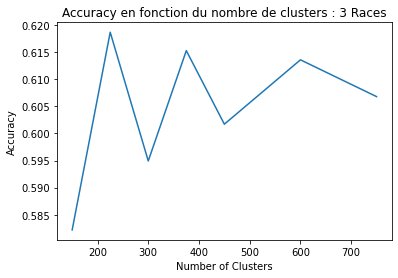

In [168]:
plt.plot(*zip(*sorted(mean_test_score.items())))
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters')
plt.title('Accuracy en fonction du nombre de clusters : 3 Races')
plt.show()

In [225]:
from sklearn.preprocessing import StandardScaler
scl2 = StandardScaler()
X_scaled = scl2.fit_transform(X_train)


import time

from sklearn.manifold import TSNE



time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

X_tsne = pd.DataFrame(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 471 samples in 0.012s...
[t-SNE] Computed neighbors for 471 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 471 / 471
[t-SNE] Mean sigma: 2.983872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.720085
[t-SNE] KL divergence after 300 iterations: 1.061388
t-SNE done! Time elapsed: 0.6539261341094971 seconds


In [226]:
X_tsne.head()

,0,1
0,-2.255800,-2.497223
1,1.700304,-0.400288
2,6.520005,-9.660542
3,2.653531,-7.744784
4,-4.276836,5.398019


(-30.0, 30.0)

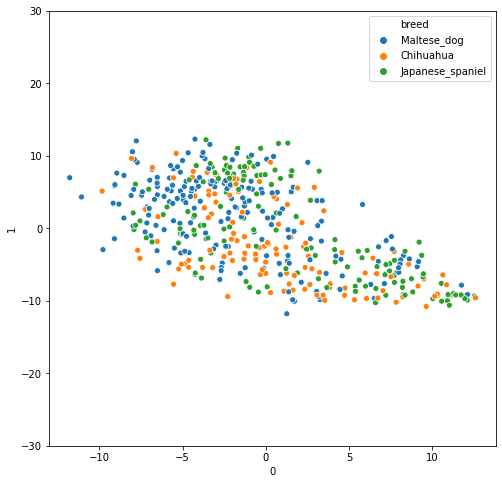

In [227]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X_tsne['breed'] = breed_train

y_train = ohe.fit_transform(X_tsne[['breed']])

import seaborn as sns

Y = X_tsne

f = plt.figure(figsize=(8, 8))
    
ax = sns.scatterplot(x=0, y=1, hue="breed",data=X_tsne)
ax.set_ylim(-30,30)

[t-SNE] Computing 117 nearest neighbors...
[t-SNE] Indexed 118 samples in 0.000s...
[t-SNE] Computed neighbors for 118 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 118 / 118
[t-SNE] Mean sigma: 4.720284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.336754
[t-SNE] KL divergence after 300 iterations: 0.729994
t-SNE done! Time elapsed: 0.1509990692138672 seconds


(-30.0, 30.0)

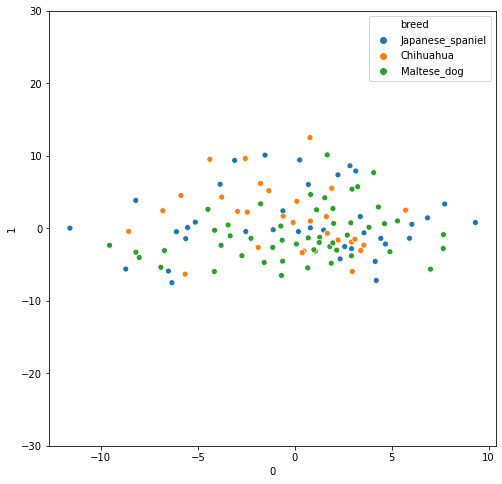

In [228]:
from sklearn.preprocessing import StandardScaler
scl2 = StandardScaler()
X_scaled = scl2.fit_transform(X_test)


import time

from sklearn.manifold import TSNE



time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

X_tsne = pd.DataFrame(X_tsne)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X_tsne['breed'] = breed_test

y_test = ohe.fit_transform(X_tsne[['breed']])

import seaborn as sns

Y = X_tsne

f = plt.figure(figsize=(8, 8))
    
ax = sns.scatterplot(x=0, y=1, hue="breed",data=X_tsne)
ax.set_ylim(-30,30)

In [3]:
accfilters = {'None': 61.86, 'Equalize': 58.47, 'Mean': 63.56, 'Gaussian' : 62.71, 'Median' : 52.54, 'Non-Local Mean' : 60.17, 'ZCA Whitening' : 55.93}

In [4]:
accfilters

{'None': 61.86,
 'Equalize': 58.47,
 'Mean': 63.56,
 'Gaussian': 62.71,
 'Median': 52.54,
 'Non-Local Mean': 60.17,
 'ZCA Whitening': 55.93}

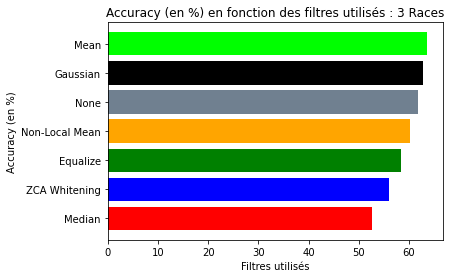

In [18]:
color = ['red','blue','green','orange','slategray','black','lime']
plt.barh(*zip(*sorted(accfilters.items(),key=lambda x: x[1])), color=color)
plt.ylabel('Accuracy (en %)')
plt.xlabel('Filtres utilisés')
plt.title('Accuracy (en %) en fonction des filtres utilisés : 3 Races')
plt.show()